<a href="https://colab.research.google.com/github/laura-turnbull-lloyd/STDH_teaching/blob/main/Lecture_4_analysing_spatial_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

Today we're going to be focussing on how to assess the spatial distribution of hazards, using landslides as an example.

You'll be working with a spatial dataset consisting of polygons representing landslides that occurred during the 2008 Mw 7.9 Wenchuan earthquake in China.

The data represent an area of 20 x 20 km.


# 2. Packages we'll be working with

GeoPandas -- which offers a pandas-like interface to working with geodata. Think of this as your tool for basic data manipulation and transformation, much like pandas. To ensure that geopandas (and its dependencies) are correctly installed, make sure you run the package install script as detailed below (there are a few issues with installing geopandas correcty on google colab!).

The other packages listed are those that you've worked with before, or packages that geopandas depends on.

In [1]:
# Colab environment (run once)
!pip -q install "geopandas>=0.14" "shapely>=2.0" "pyproj>=3.6" "rtree>=1.3.0" "seaborn>=0.13" "pointpats"


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 507.6/507.6 kB 5.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 63.5/63.5 kB 1.4 MB/s eta 0:00:00


In [29]:
import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt, seaborn as sns, requests, zipfile, io
from shapely.geometry import Point, box, Polygon
# to make sure that pandas outputs values in an easy to read format, we can customise the output format:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern
)


# 3. Reading in landslide data
The data have been provided for you in a shapefile format, in a zipped up file for you on GitHub. In the script below, you will automatically extract the data from GitHub (so no need to download it).

In case you also wish to explore the data in a more traditional Geogrpahical Infromation System (e.g. ArcPro or QGIS), I have also provided the data for you on Learn Ultra on this weeks page.


To read in the data from GitHub:

In [4]:
# read in data that's provided for you on Github
url = "https://github.com/laura-turnbull-lloyd/STDH_teaching/raw/main/landslides_clip.zip"

# Download the zip file into memory
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# read in the shapefile
z.extractall("landslides_clip")
LS = gpd.read_file("landslides_clip") # this reads in the landslide data

To view the first few lines of the data:

In [6]:


# View the header info of the landslide data we've just read in
print(LS.head())


      ID   area_rob data                                           geometry
0  37469  500.00000  rnp  POLYGON ((376386.922 3469995, 376366.922 34699...
1  37470 1600.00000  rnp  POLYGON ((383916.922 3469995, 383896.922 34699...
2  37471 3100.00000  rnp  POLYGON ((384546.922 3469995, 384536.922 34699...
3  37475 3800.00000  rnp  POLYGON ((377946.922 3469995, 377946.922 34699...
4  37476 2500.00000  rnp  POLYGON ((388336.922 3469985, 388316.922 34699...


Alternatively we can print out the whole dataset which will show us the first and last few lines in the dataset:

In [ ]:
#Printing out the whole dataset
print(LS)

You can see that there are 6604 rows in the data, which means there are 6604 individual landslide polygons.

Note that python is a bit wierd in that it starts its index numbering from zero.

Each row in the landslide dataset contains a unique identifier (in column ID), the area of the polygon in m2 (area_rob), the initials of the person who mapped it (data), and the geometry of the data (geometry). These attributes are linked to each individual landslide polygon.

Using the `gpd.read_file`command, you read the data into a a 'geodataframe', which is very similar to a traditional, non-spatial pandas DataFrame, but with an additional column called geometry.

# 4. Determining the coordinate system of the data
It's important to be aware of the coordinate system if the data you're working with. You can find it out using the ```crs``` command. It's easy to make mistakes in spatial data analysis when you aren't aware of the coordinate system of your data. This becomes even more important when you are working with more than one dataset.



In [8]:
LS.crs

<Projected CRS: EPSG:32648>
Name: WGS 84 / UTM zone 48N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102¬∞E and 108¬∞E, northern hemisphere between equator and 84¬∞N, onshore and offshore. Cambodia. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Russian Federation. Singapore. Thailand. Vietnam.
- bounds: (102.0, 0.0, 108.0, 84.0)
Coordinate Operation:
- name: UTM zone 48N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# 5. Plotting spatial data
We can plot the raw spatial data using the code below. In this code, we undertake the following steps:
1. Create a figure named `f` with one axis named `ax` by using the command plt.subplots (part of the library matplotlib, which we have imported at the top of the notebook).
Note how the method is returning two elements and we can assign each of them to objects with different name (`f` and `ax`) by simply listing them at the front of the line, separated by commas.
2. We plot the geographies and tell the function that we want it to draw the polygons on the axis we are passing, ax. This method returns the axis with the geographies in them, so we make sure to store it on an object with the same name, `ax`.
3. We draw the entire plot by calling `plt.show()`.

For more information on matplotlib plotting conventions, see [here](https://matplotlib.org/).

You can also save figures outside of this notebook, using the ```plt.savefig``` command -- see below for an example. Any figures you save will be saved in the current working directory and therefore will need to be moved if you want to access them after the session has ended.



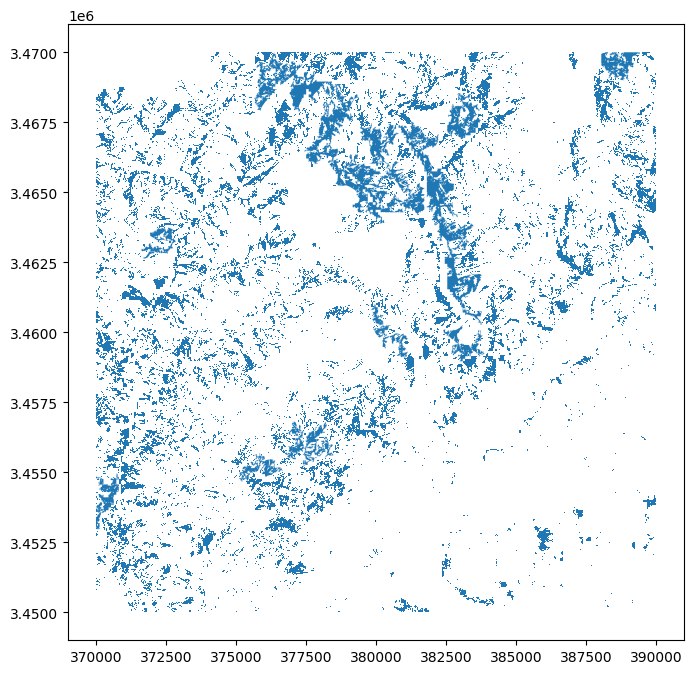

<Figure size 640x480 with 0 Axes>

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(16, 8))
# Plot layer of polygons on the axis
LS.plot(ax=ax)
# Remove axis frames
#ax.set_axis_off()
# Display
plt.show()

# Save figure to a PNG file
plt.savefig('Wenchuan_landslides.png')

plt.tight_layout()

# For a very high resolution image we can add the dpi in the command, e.g.
#plt.savefig('Wenchuan_landslides.png', dpi = 1080) # I've left this line commented, as you don't need to run it for now.


# 6. Exploratory data analysis
As we've established over the previous weeks, it's always useful to undertake exploratory data analysis to establish key characteristics about the data (hazard) that we're working with.

We can use the pandas summary statistics (describe) function to be able to explore the data.

The describe funciton gives the:
> count

> mean

> standard deviation

> minimum

> 25 percentile

> 50 percentile

> 75 percentiles

> max

of all numeric columns in the dataset


In [9]:
LS.describe()

ID      area_rob
count  6604.00000    6604.00000
mean  45827.33677    9574.74258
std    4891.00143   81665.57068
min   37469.00000     400.00000
25%   41495.75000     600.00000
50%   45753.50000    1100.00000
75%   49935.25000    3000.00000
max   54883.00000 3197700.00000

**What's the maximum landslide size (including correct units)?**



For other summary infromation that is not given by the describe function, we can calculate this manually. For instance, we might be interested in the total area of landslides in the study area. We can calculate this using the pandas 'series sum' function.

In [10]:
total_area = pd.Series(LS['area_rob'].sum(), index=['area_rob'])
print(total_area)

area_rob   63231600.00000
dtype: float64


**What's the total area affected by landslides in the study area?**

**What percentage of the entire study area is affected by landslides?**
To answer this question you will have to undertake a further calculation which you can enter below:




In [ ]:
# Add your calculations here in order to answer the above question:

To see how I did it, you can click 'show code' below, but do have a go at figuring this out for yourself first!

In [ ]:
# @title
study_area = 20000*20000
percent_LS = total_area/study_area*100
percent_LS

# 7. Point pattern analysis: testing if there is a spatial pattern

We can begin by asking a fundamental question: **Are landslides randomly distributed across the study area, or do they show spatial patterning?**

To be able to use the toolbox of point pattern analysis answer this question, we first need to represent the data (in this case, landslides) as points.

To do this we extract a point (the centroid) from the landslide polygons that

*   List item
*   List item

we've just been exploring.

In [12]:
#extracting points from the landslide polygons
points = LS.copy()
# change geometry
points['geometry'] = points['geometry'].centroid
points

ID     area_rob data                        geometry
0     37469    500.00000  rnp    POINT (376376.922 3469997.5)
1     37470   1600.00000  rnp    POINT (383906.922 3469997.5)
2     37471   3100.00000  rnp    POINT (384541.922 3469997.5)
3     37475   3800.00000  rnp  POINT (377949.065 3469995.357)
4     37476   2500.00000  rnp  POINT (388329.065 3469993.214)
...     ...          ...  ...                             ...
6599  54720   2200.00000  rnp    POINT (373541.922 3450005.5)
6600  54731   4100.00000  rnp  POINT (377748.589 3450009.167)
6601  54756  12500.00000  rnp  POINT (375036.838 3450023.517)
6602  54882  14500.00000  rnp  POINT (373357.247 3450038.604)
6603  54883 107800.00000  rnp  POINT (381695.387 3450064.207)

[6604 rows x 4 columns]

As we've already established, the first step to get a sense of what the spatial dimension of this dataset looks like is to plot it.

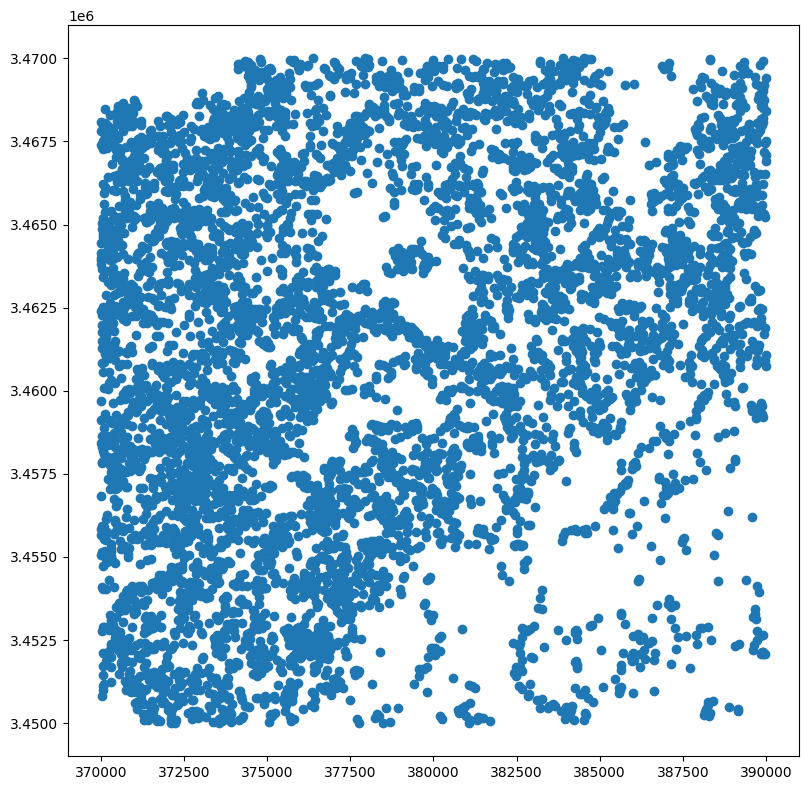

In [13]:
f, ax = plt.subplots(1, figsize=(12, 8))
points.plot(ax=ax) # this is the landslide data represented as points
plt.autoscale(True)
plt.tight_layout()

NOw that we've got the landslide data in a point format, we can test this observed point pattern against **complete spatial randomness (CSR)**, where there is neither clustering nor dispersion.

We can do this by using the ```pointspats``` package to simulate CSR from a given point set, using the ```pointpats.random``` module, which creates a random dataset, based on the landslide dataset (i.e., it shares the same geomoetry and has the same number of points), that exhibits complete spatial randomness:


In [16]:
#create CSR from the point data set

# first, we extract the x and y coordinates of each point
points["x"] = points.geometry.x
points["y"] = points.geometry.y

# then we create a list of coordinates
coordinates = points[["x", "y"]].values

# then we shuffle everything up
random_pattern = random.poisson(coordinates, size=len(coordinates))

Let's compare the random pattern with the
observed landslide pattern.

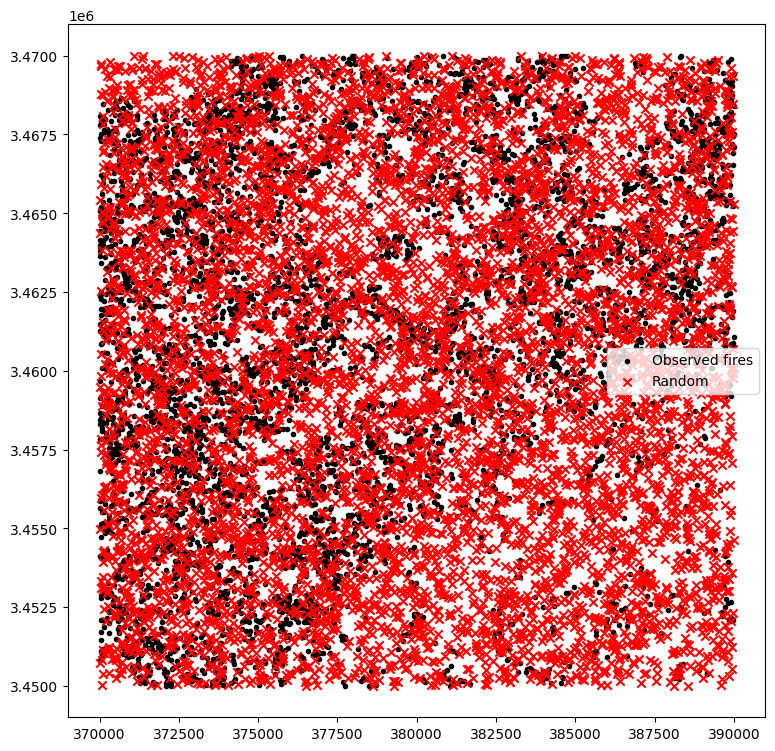

In [17]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(
    *coordinates.T,
    color="k",
    marker=".",
    label="Observed landslides"
)
plt.scatter(*random_pattern.T, color="r", marker="x", label="Random")
ax.legend(ncol=1, loc="right")
plt.show()

Now we're going to test whether the landslide data exhibit a spatial pattern or not, by dividing the region into a grid of equal-size quadrats (cells) and then counting how many landslides fall in each cell.

By examining whether observations are spread evenly over cells, this quadrat approach aims to estimate whether points are spread out, or if they are clustered into a few cells.

In python, using the pointpats package, we can visualize the point data, and how the points are counted within each grid cell. We can do this using the  ``QStatistic.plot()`` method.

<Axes: title={'center': 'Quadrat Count'}>

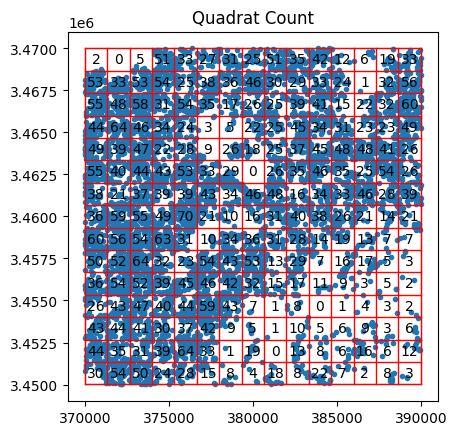

In [19]:
qstat = QStatistic(coordinates, nx=15, ny=15) # nx and ny are the number of cells in the x and y directions
qstat.plot()

Here, for a 15 x 15 grid (note that this is specified in the code block above) spanning the point pattern, we can see a mix of very high values and very low values.

We can use the $X^2$ test statistic to test if the pattern is random or not, which is expressed as:
$$
\chi^2 = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i}
$$
where $O_i$ is the observed count in quadrat ùëñ, $E_i$ is the expected count under CSR (same overall intensity), and $k$ is the number of quadrats.

If  $X^2$ is small and the p-value is large (p > 0.05), the pattern is consistent with CSR.

If  $X^2$ is large and p < 0.05, the pattern departs from randomness, suggesting clustering or regular spacing.

At this point, the test tells us whether the pattern is clustered, but not where or by how much.

Let's have a look at the $X^2$ statistics for the landslide point dataset...


In [26]:
print("chi2 p value", qstat.chi2_pvalue)
print("chi2 value", qstat.chi2)

chi2_pvalue 0.0
chi2 value 2364.7235009085402


We have a significant P-value and a very high $X^2$ statistic, telling us that the landslide data significantly deviate from CSR.  

Now, let's repeat the analysis for the randomly distributed dataset that we generated, and view the resulting stats:

chi2 p value 0.41741075898315916
chi2 value 227.7686250757117


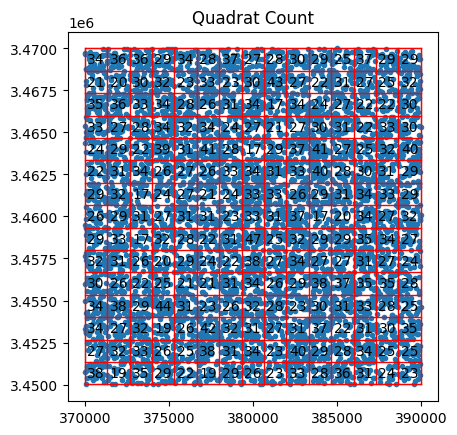

In [27]:
qstat_rand = QStatistic(random_pattern, nx=15, ny=15)
qstat_rand.plot()
print("chi2 p value", qstat_rand.chi2_pvalue)
print("chi2 value", qstat_rand.chi2)

**What does this analysis show? Can you think of any potential issues with the above analysis?**

**Take home message:** At this point, this analysis tells is us whether the pattern is clustered (across the whole study area), but not where or by how much.

# 8. Visualizing patterns more clearly: point density

We can extend the quadrat approach used in the previous section, where we counted the number of landslides in each cell, to view it as a spatial or 2-D histogram.

To do this from scratch, we generate a regular grid (either squared or hexagonal), and count how many dots fall within each grid cell. This is attractive because it is simple and intuitive.

First, let's create the regular grid.

In [30]:
# total area for the grid
xmin, ymin, xmax, ymax= LS.total_bounds # this function extracts the bounding coordinates of the landslide data
width = 500 # this sets the size of the grid cell width
height = 500 # this sets the size of the grid cell width
# projection of the grid - this sets the crs to be the same as the data we area already working with
crs = LS.crs
rows = int(np.ceil((ymax-ymin) /  height))
cols = int(np.ceil((xmax-xmin) / width))
XleftOrigin = xmin
XrightOrigin = xmin + width
YtopOrigin = ymax
YbottomOrigin = ymax- height
polygons = []
for i in range(cols):
   Ytop = YtopOrigin
   Ybottom =YbottomOrigin
   for j in range(rows):
       polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)]))
       Ytop = Ytop - height
       Ybottom = Ybottom - height
   XleftOrigin = XleftOrigin + width
   XrightOrigin = XrightOrigin + width

grid = gpd.GeoDataFrame({'geometry':polygons}, crs=crs)
grid

geometry
0     POLYGON ((370000 3470000, 370500 3470000, 3705...
1     POLYGON ((370000 3469500, 370500 3469500, 3705...
2     POLYGON ((370000 3469000, 370500 3469000, 3705...
3     POLYGON ((370000 3468500, 370500 3468500, 3705...
4     POLYGON ((370000 3468000, 370500 3468000, 3705...
...                                                 ...
1595  POLYGON ((389500 3452500, 390000 3452500, 3900...
1596  POLYGON ((389500 3452000, 390000 3452000, 3900...
1597  POLYGON ((389500 3451500, 390000 3451500, 3900...
1598  POLYGON ((389500 3451000, 390000 3451000, 3900...
1599  POLYGON ((389500 3450500, 390000 3450500, 3900...

[1600 rows x 1 columns]

Next, we'll create a new object called `landslide_count` and store the result of a spatial join between landslide points and the grid.

In [31]:
landslide_count = gpd.sjoin(grid, points, how='left', predicate ='contains')
landslide_count

geometry  index_right  \
0     POLYGON ((370000 3470000, 370500 3470000, 3705...          NaN   
1     POLYGON ((370000 3469500, 370500 3469500, 3705...          NaN   
2     POLYGON ((370000 3469000, 370500 3469000, 3705...    421.00000   
3     POLYGON ((370000 3468500, 370500 3468500, 3705...    611.00000   
3     POLYGON ((370000 3468500, 370500 3468500, 3705...    603.00000   
...                                                 ...          ...   
1595  POLYGON ((389500 3452500, 390000 3452500, 3900...   6047.00000   
1596  POLYGON ((389500 3452000, 390000 3452000, 3900...          NaN   
1597  POLYGON ((389500 3451500, 390000 3451500, 3900...          NaN   
1598  POLYGON ((389500 3451000, 390000 3451000, 3900...          NaN   
1599  POLYGON ((389500 3450500, 390000 3450500, 3900...          NaN   

              ID   area_rob data            x             y  
0            NaN        NaN  NaN          NaN           NaN  
1            NaN        NaN  NaN          NaN           NaN  
2    38677.00000  900.00000  rnp 370498.58891 3468513.33333  
3    39067.00000  400.00000  rnp 370186.92225 3468005.00000  
3    39048.00000 2200.00000  rnp 370111.46770 3468045.90909  
...          ...        ...  ...          ...           ...  
1595 52948.00000 1200.00000  rnp 389727.75558 3452494.16667  
1596         NaN        NaN  NaN          NaN           NaN  
1597         NaN        NaN  NaN          NaN           NaN  
1598         NaN        NaN  NaN          NaN           NaN  
1599         NaN        NaN  NaN          NaN           NaN  

[6926 rows x 7 columns]

In the above table, NaN means "Not a number", and this happens when the count function didn't count a landslide in a particular cell.

Each landslide carries the ID of its corresponding grid cell (on the far left of the above table). Let's explicitly add this grid cell ID to the geodataframe:

In [32]:
landslide_count['grid_index'] = landslide_count.index
landslide_count

geometry  index_right  \
0     POLYGON ((370000 3470000, 370500 3470000, 3705...          NaN   
1     POLYGON ((370000 3469500, 370500 3469500, 3705...          NaN   
2     POLYGON ((370000 3469000, 370500 3469000, 3705...    421.00000   
3     POLYGON ((370000 3468500, 370500 3468500, 3705...    611.00000   
3     POLYGON ((370000 3468500, 370500 3468500, 3705...    603.00000   
...                                                 ...          ...   
1595  POLYGON ((389500 3452500, 390000 3452500, 3900...   6047.00000   
1596  POLYGON ((389500 3452000, 390000 3452000, 3900...          NaN   
1597  POLYGON ((389500 3451500, 390000 3451500, 3900...          NaN   
1598  POLYGON ((389500 3451000, 390000 3451000, 3900...          NaN   
1599  POLYGON ((389500 3450500, 390000 3450500, 3900...          NaN   

              ID   area_rob data            x             y  grid_index  
0            NaN        NaN  NaN          NaN           NaN           0  
1            NaN        NaN  NaN          NaN           NaN           1  
2    38677.00000  900.00000  rnp 370498.58891 3468513.33333           2  
3    39067.00000  400.00000  rnp 370186.92225 3468005.00000           3  
3    39048.00000 2200.00000  rnp 370111.46770 3468045.90909           3  
...          ...        ...  ...          ...           ...         ...  
1595 52948.00000 1200.00000  rnp 389727.75558 3452494.16667        1595  
1596         NaN        NaN  NaN          NaN           NaN        1596  
1597         NaN        NaN  NaN          NaN           NaN        1597  
1598         NaN        NaN  NaN          NaN           NaN        1598  
1599         NaN        NaN  NaN          NaN           NaN        1599  

[6926 rows x 8 columns]

Now we want to count the number of landslides in each grid cell. We can do this using the dissolve tool (which simplifies data), counting the number of landslides within each grid cell.

In [33]:
landslide_count_dissolve = landslide_count.dissolve(by='grid_index', aggfunc='count')
landslide_count_dissolve

geometry  index_right  \
grid_index                                                                   
0           POLYGON ((370000 3470000, 370500 3470000, 3705...            0   
1           POLYGON ((370000 3469500, 370500 3469500, 3705...            0   
2           POLYGON ((370000 3469000, 370500 3469000, 3705...            1   
3           POLYGON ((370500 3468000, 370000 3468000, 3700...            7   
4           POLYGON ((370000 3467500, 370000 3468000, 3705...           11   
...                                                       ...          ...   
1595        POLYGON ((389500 3452000, 389500 3452500, 3900...            8   
1596        POLYGON ((389500 3452000, 390000 3452000, 3900...            0   
1597        POLYGON ((389500 3451500, 390000 3451500, 3900...            0   
1598        POLYGON ((389500 3451000, 390000 3451000, 3900...            0   
1599        POLYGON ((389500 3450500, 390000 3450500, 3900...            0   

            ID  area_rob  data   x   y  
grid_index                              
0            0         0     0   0   0  
1            0         0     0   0   0  
2            1         1     1   1   1  
3            7         7     7   7   7  
4           11        11    11  11  11  
...         ..       ...   ...  ..  ..  
1595         8         8     8   8   8  
1596         0         0     0   0   0  
1597         0         0     0   0   0  
1598         0         0     0   0   0  
1599         0         0     0   0   0  

[1600 rows x 7 columns]

In the table above, you can see that for the attributes that were associated with the landslide point data, you now have the 'count' of how many landslides there were in each grid cell.

So, for example, for grid cell with an index of 3, there were 7 landslide points within that cell. Whilst for grid cell with an index of 0, there were 0 landslides.

We can now plot out the resulting landslide point density map.

<Axes: >

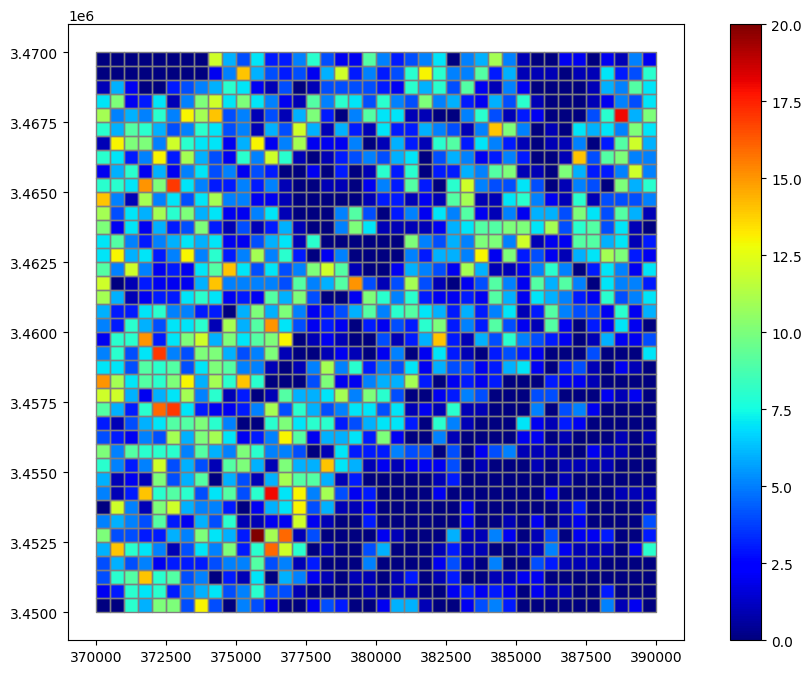

In [34]:
f, ax = plt.subplots(1, figsize=(12, 8))
landslide_count_dissolve.plot(ax=ax, column='index_right', cmap='jet', legend = True) # here, cmap = 'jet' specifies the colour ramp I've chosen to use.
plt.autoscale(True)
grid.plot(ax=ax, facecolor="none", edgecolor='grey') # this is where you overlay the grid

# 8. Visualizing patterns more clearly: kernel density estimate

We can also summarise the spatial distribution of points using a kernel density function. This is simple to achieve using the `seaborn package`.

A kernel density function replaces plotting every single point by estimating the continuous observed probability distribution. It's not too dissimilar to the point density counts that you've just carried out, but it differs in that it creates a surface that models the probability of point density over space.

The idea behind kernel density estimates (KDEs) is to count the number of points in a continious way. Instead of using discrete counting, where you include a point in the count if it is inside a certain boundary and ignore it otherwise, KDEs use functions (kernels) that include points but give different weights to each one depending of how far of the location where we are counting the point is.

Creating a kernel density estimate is very straightfoward in Python. In its simplest form, we can run the following single line of code:

<Axes: xlabel='x', ylabel='y'>

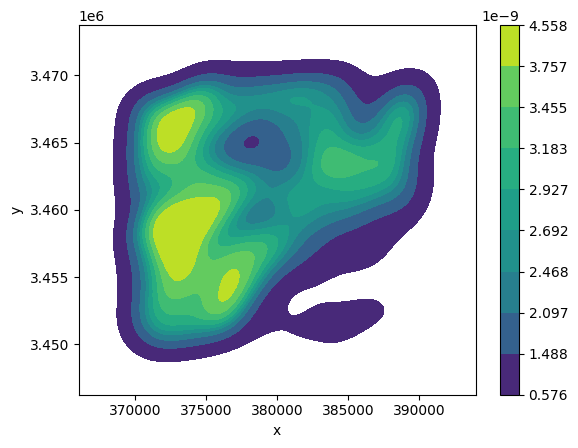

In [37]:
sns.kdeplot(data = points, x = "x", y = "y", fill=True, cmap='viridis', cbar = True)

Much like with the bin size in the histogram, the ability of the kernel density estimate to accurately represent the data depends on the choice of the bandwidth, which essentially represents the radius of smoothing.

An over-smoothed estimate might erase meaningful patterns, but an under-smoothed estimate can obscure the true patterns within random noise.

The easiest way to check the robustness of the estimate is to adjust the default bandwidth (which is a backend calculation in seaborn using scipy, and is based on the distribution of the data).

To do this, we can add a bw_adjust function (```bw_adjust = 0.5```) to the code below, and have a play around to see how different values of bw_adjust alter the resulting kernel density estimation.

<Axes: xlabel='x', ylabel='y'>

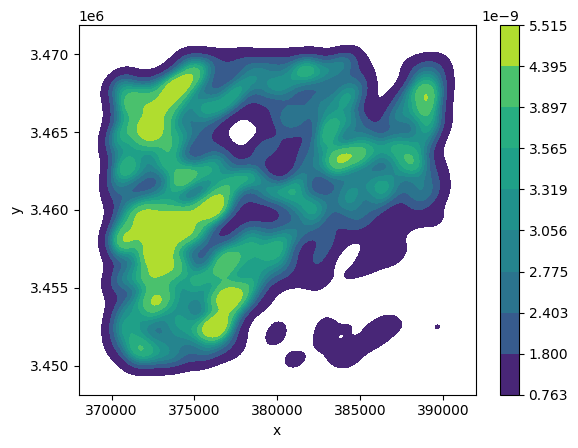

In [38]:
sns.kdeplot(data = points, x = "x", y = "y", fill=True, cmap='viridis', cbar = True, bw_adjust = 0.5)

You can read more about the different parameter options for kernel density estimates using the seaborn package [here](https://seaborn.pydata.org/generated/seaborn.kdeplot.html).

In summary:
A KDE with a small bandwidth ‚Üí fine detail, local patterns
*   Produces a highly detailed surface with many small peaks
*   Highlights local clusters and sharp changes in density
*   May appear noisy ‚Äî individual landslides dominate the surface
*   Useful for identifying hotspots at slope or hillslope scale

A KDE with a larger bandwidth ‚Üí broad smoothing, regional trends
*   Each landslide influences a larger area ‚Üí generalized pattern
*   Emphasizes broader-scale patterns
*   Can mask local variability and small clusters

#Exercise 2: Landslide area density
To undertake density calculations, we need to divide the study area up into regions within which we are going to undertake density calculations.

We can do this using the geopandas package.




Plotting the grid over the data shows how the landslides are generally clustered into a few regions and we‚Äôll end up with many ‚Äúempty‚Äù grid cells:

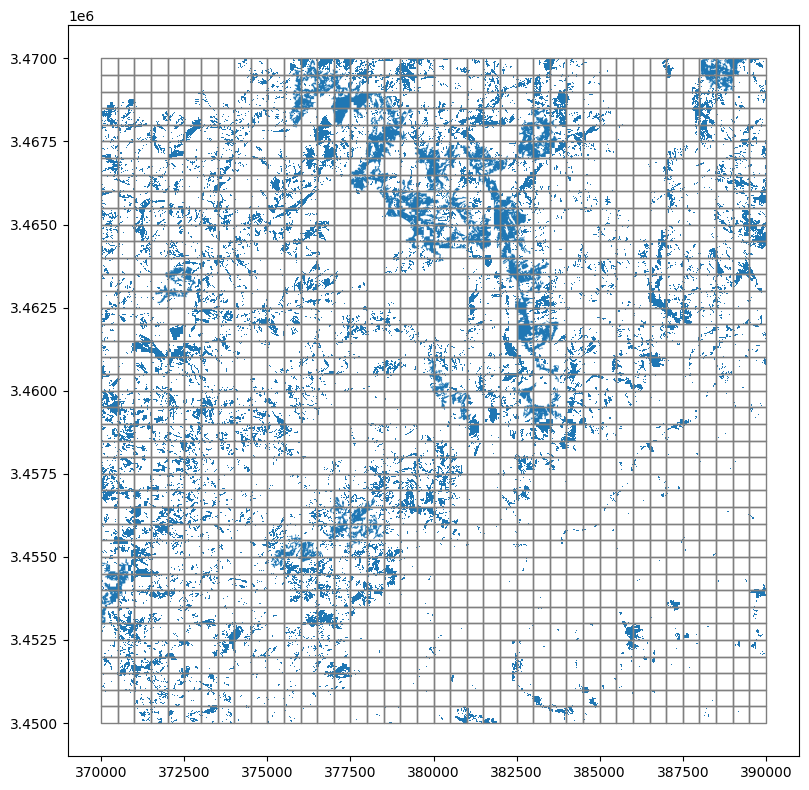

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 8))
LS.plot(ax=ax) # this is the landslide data
plt.autoscale(True)
grid.plot(ax=ax, facecolor="none", edgecolor='grey') # this is where you overlay the grid!
plt.tight_layout()

We‚Äôre going to determine the area of landslides in each square polygon. This takes a couple of steps in GeoPandas.

First, we use the intersect tool to divide up the landslide polygons based on the grid cells. Then we calculate the area of each fragmented landslide polygon, and add the landslide index to the dataframe (just to make sure it gets carried over into the subsequent analysis).

In [ ]:
#LS_intersection = LS.overlay(cell, keep_geom_type = False)
LS_intersect = LS.overlay(grid, how='intersection', keep_geom_type=False)
LS_intersect['LS_area'] =LS_intersect.apply(lambda row: row.geometry.area,axis=1) # calculate the area of each landslide segment
LS_intersect['LS_index'] = LS_intersect.index
print(LS_intersect)


         ID     area_rob data  \
0     37469    500.00000  rnp   
1     37470   1600.00000  rnp   
2     37471   3100.00000  rnp   
3     37475   3800.00000  rnp   
4     37476   2500.00000  rnp   
...     ...          ...  ...   
9043  54756  12500.00000  rnp   
9044  54756  12500.00000  rnp   
9045  54882  14500.00000  rnp   
9046  54883 107800.00000  rnp   
9047  54883 107800.00000  rnp   

                                               geometry     LS_area  LS_index  
0     POLYGON ((376366.922 3469995, 376366.922 34700...   100.00000         0  
1     POLYGON ((383896.922 3469995, 383896.922 34700...   100.00000         1  
2     POLYGON ((384536.922 3469995, 384536.922 34700...    50.00000         2  
3     POLYGON ((377946.922 3469985, 377936.922 34699...   350.00000         3  
4     POLYGON ((388316.922 3469985, 388316.922 34700...   350.00000         4  
...                                                 ...         ...       ...  
9043  MULTIPOLYGON (((374996.922 3450005, 3

We can plot out the data to check it looks sensible...

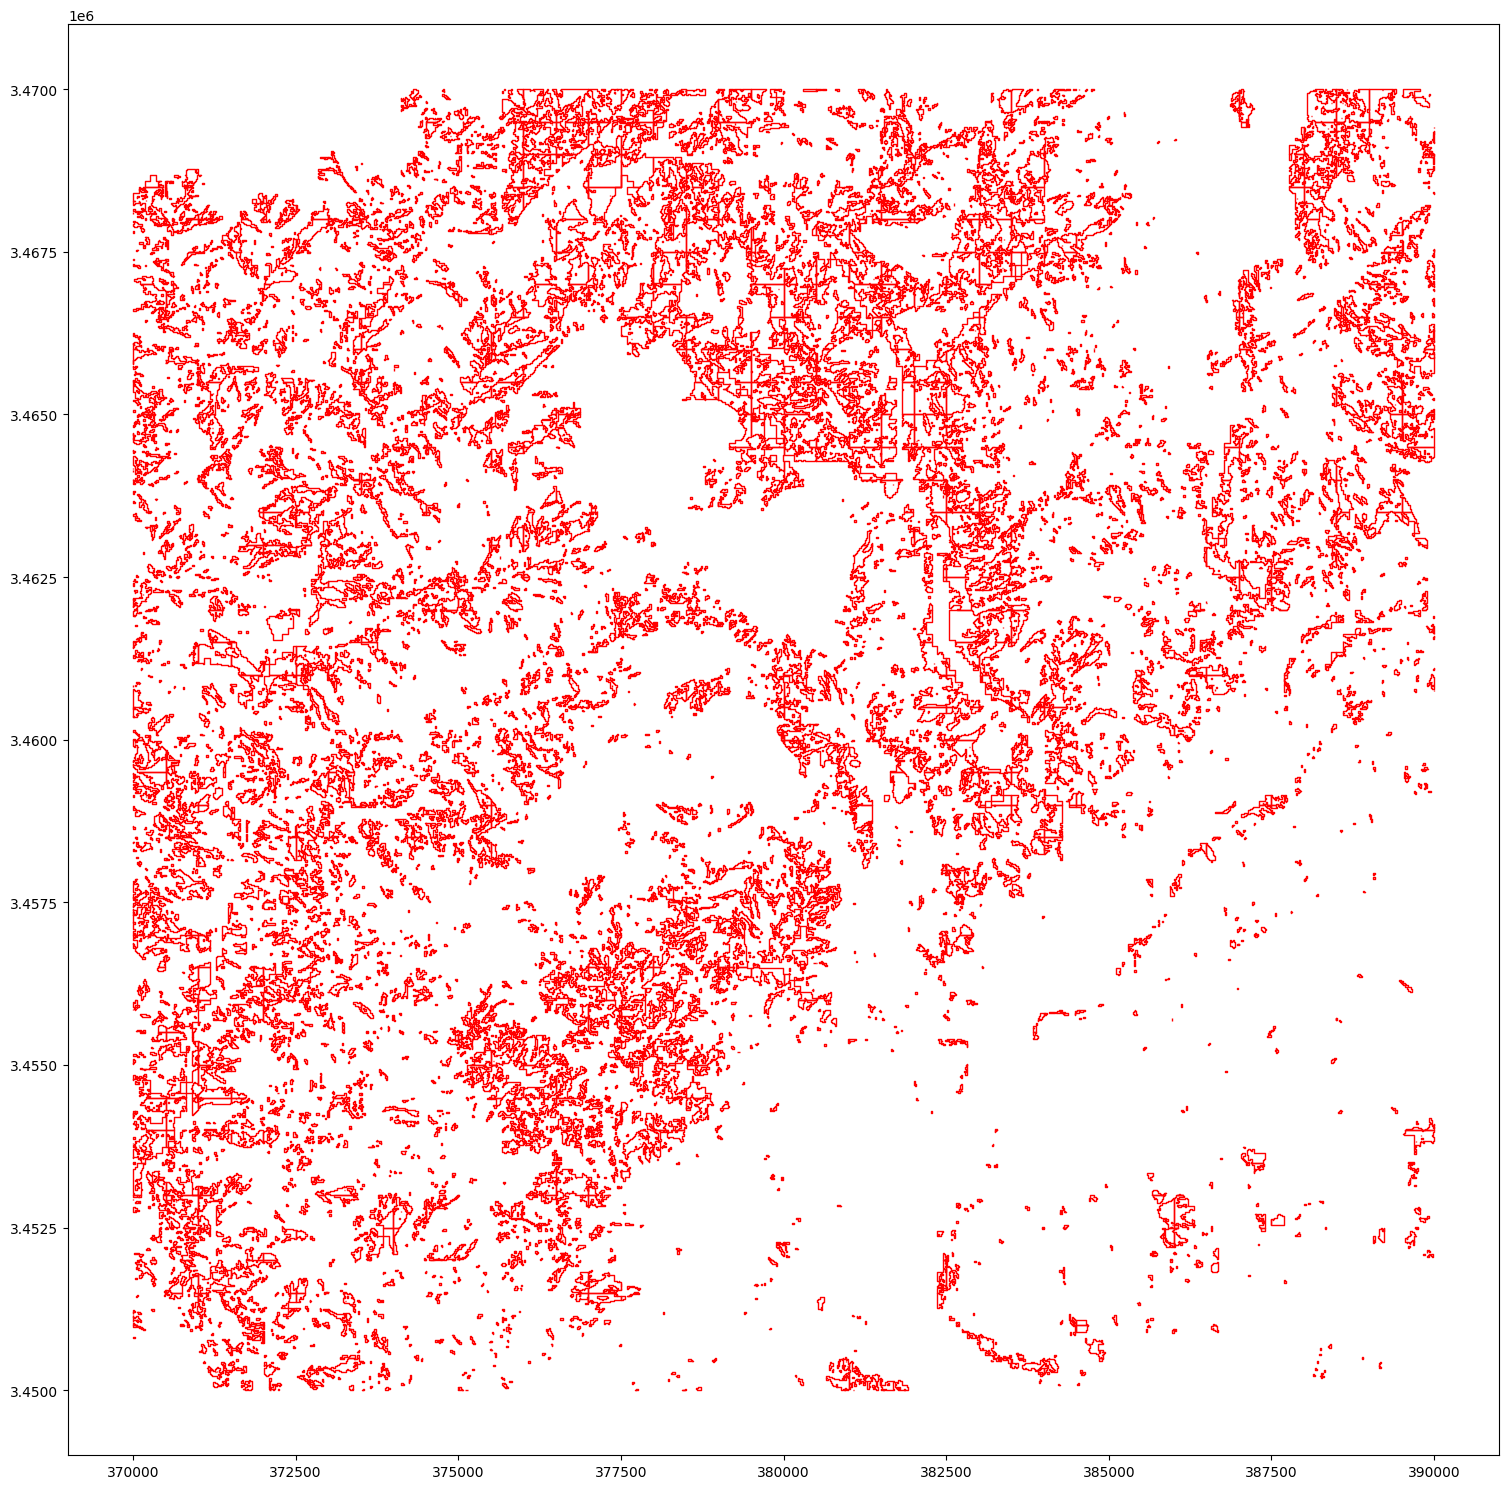

In [ ]:
f, ax = plt.subplots(1, figsize=(25, 15))
LS_intersect.plot(ax=ax, facecolor = "none", edgecolor = 'red')
#plt.autoscale(True)
plt.tight_layout()
#cell.plot(ax=ax, facecolor="none")#, edgecolor='grey') # this is where you overlay the grid

This looks good. You can clearly see where landslide polygons have been divided up where they cross grid cells.

The next task is to undertake a spatial join, to join the landslide data to the grid.We do this using the geopandas spatial join, ```sjoin``` tool.



In [ ]:
merged = gpd.sjoin(grid, LS_intersect, predicate = 'contains', how='left')
merged

geometry  index_right  \
0     POLYGON ((370000 3470000, 370500 3470000, 3705...          NaN   
1     POLYGON ((370000 3469500, 370500 3469500, 3705...          NaN   
2     POLYGON ((370000 3469000, 370500 3469000, 3705...    553.00000   
2     POLYGON ((370000 3469000, 370500 3469000, 3705...    514.00000   
2     POLYGON ((370000 3469000, 370500 3469000, 3705...   1013.00000   
...                                                 ...          ...   
1595  POLYGON ((389500 3452500, 390000 3452500, 3900...   8323.00000   
1596  POLYGON ((389500 3452000, 390000 3452000, 3900...          NaN   
1597  POLYGON ((389500 3451500, 390000 3451500, 3900...          NaN   
1598  POLYGON ((389500 3451000, 390000 3451000, 3900...          NaN   
1599  POLYGON ((389500 3450500, 390000 3450500, 3900...          NaN   

              ID     area_rob data     LS_area   LS_index  
0            NaN          NaN  NaN         NaN        NaN  
1            NaN          NaN  NaN         NaN        NaN  
2    38677.00000    900.00000  rnp   388.49892  553.00000  
2    38608.00000    900.00000  rnp    92.33261  514.00000  
2    39289.00000 174100.00000  rnp 30700.00000 1013.00000  
...          ...          ...  ...         ...        ...  
1595 52948.00000   1200.00000  rnp   800.00000 8323.00000  
1596         NaN          NaN  NaN         NaN        NaN  
1597         NaN          NaN  NaN         NaN        NaN  
1598         NaN          NaN  NaN         NaN        NaN  
1599         NaN          NaN  NaN         NaN        NaN  

[9321 rows x 7 columns]

**Why do you think that some rows in the dataframe have NaN values?**

As we did before, we'll add the grid index to the dataframe:

In [ ]:
merged['grid_index'] = merged.index # here, we add the index of the cells covering the study area into the dataframe so that we can use this in our analysis

In [ ]:
merged

geometry  index_right  \
0     POLYGON ((370000 3470000, 370500 3470000, 3705...          NaN   
1     POLYGON ((370000 3469500, 370500 3469500, 3705...          NaN   
2     POLYGON ((370000 3469000, 370500 3469000, 3705...    553.00000   
2     POLYGON ((370000 3469000, 370500 3469000, 3705...    514.00000   
2     POLYGON ((370000 3469000, 370500 3469000, 3705...   1013.00000   
...                                                 ...          ...   
1595  POLYGON ((389500 3452500, 390000 3452500, 3900...   8323.00000   
1596  POLYGON ((389500 3452000, 390000 3452000, 3900...          NaN   
1597  POLYGON ((389500 3451500, 390000 3451500, 3900...          NaN   
1598  POLYGON ((389500 3451000, 390000 3451000, 3900...          NaN   
1599  POLYGON ((389500 3450500, 390000 3450500, 3900...          NaN   

              ID     area_rob data     LS_area   LS_index  grid_index  
0            NaN          NaN  NaN         NaN        NaN           0  
1            NaN          NaN  NaN         NaN        NaN           1  
2    38677.00000    900.00000  rnp   388.49892  553.00000           2  
2    38608.00000    900.00000  rnp    92.33261  514.00000           2  
2    39289.00000 174100.00000  rnp 30700.00000 1013.00000           2  
...          ...          ...  ...         ...        ...         ...  
1595 52948.00000   1200.00000  rnp   800.00000 8323.00000        1595  
1596         NaN          NaN  NaN         NaN        NaN        1596  
1597         NaN          NaN  NaN         NaN        NaN        1597  
1598         NaN          NaN  NaN         NaN        NaN        1598  
1599         NaN          NaN  NaN         NaN        NaN        1599  

[9321 rows x 8 columns]

Now we want to sum up the area of landslides in each grid cell. In case there are more than one landslide per grid cell, we can dissolve the data, i.e. making the data more sparse, or in otherwords combine information (landslide area) from individual landslide polygons, to a total landslide area per grid cell.

In [ ]:
# Compute stats per grid cell -- aggregate landslides to grid cells with dissolve
dissolve_merged = merged.dissolve(by='grid_index', aggfunc='sum') # sums up all the values in the area column
dissolve_merged

geometry  index_right  \
grid_index                                                                   
0           POLYGON ((370000 3470000, 370500 3470000, 3705...      0.00000   
1           POLYGON ((370000 3469500, 370500 3469500, 3705...      0.00000   
2           POLYGON ((370500 3469000, 370500 3468500, 3700...   2080.00000   
3           POLYGON ((370000 3468000, 370000 3468500, 3705...   6491.00000   
4           POLYGON ((370000 3467500, 370000 3468000, 3705...  15528.00000   
...                                                       ...          ...   
1595        POLYGON ((389500 3452000, 389500 3452500, 3900...  67540.00000   
1596        POLYGON ((389500 3452000, 390000 3452000, 3900...      0.00000   
1597        POLYGON ((389500 3451500, 390000 3451500, 3900...      0.00000   
1598        POLYGON ((389500 3451000, 390000 3451000, 3900...      0.00000   
1599        POLYGON ((389500 3450500, 390000 3450500, 3900...      0.00000   

                     ID     area_rob  \
grid_index                             
0               0.00000      0.00000   
1               0.00000      0.00000   
2          116574.00000 175900.00000   
3          350357.00000 186000.00000   
4          590421.00000 211200.00000   
...                 ...          ...   
1595       425425.00000  22000.00000   
1596            0.00000      0.00000   
1597            0.00000      0.00000   
1598            0.00000      0.00000   
1599            0.00000      0.00000   

                                                     data      LS_area  \
grid_index                                                               
0                                                       0      0.00000   
1                                                       0      0.00000   
2                                               rnprnprnp  31180.83153   
3                             rnprnprnprnprnprnprnprnprnp 123234.55724   
4           rnprnprnprnprnprnprnprnprnprnprnprnprnprnprnp  39973.16414   
...                                                   ...          ...   
1595                             rnprnprnprnprnprnprnprnp  21600.00000   
1596                                                    0      0.00000   
1597                                                    0      0.00000   
1598                                                    0      0.00000   
1599                                                    0      0.00000   

              LS_index  
grid_index              
0              0.00000  
1              0.00000  
2           2080.00000  
3           6491.00000  
4          15528.00000  
...                ...  
1595       67540.00000  
1596           0.00000  
1597           0.00000  
1598           0.00000  
1599           0.00000  

[1600 rows x 7 columns]

Next, to help with landslide area density calculations, we need to total area of each grid cell. There are multiple ways we can calculate this (we specified the dimensions of each grid cell earlier). I always like to calculate dimensions based on the actual data, as there's less room for error.

In [ ]:
dissolve_merged['cellarea'] =dissolve_merged.apply(lambda row: row.geometry.area,axis=1)
dissolve_merged

# Note that when you write out the dataframe, there's a little blue pen, which you can click to work interactivley with the dataframe, for instance if you want to interrogate the data manually.

geometry  index_right  \
grid_index                                                                   
0           POLYGON ((370000 3470000, 370500 3470000, 3705...      0.00000   
1           POLYGON ((370000 3469500, 370500 3469500, 3705...      0.00000   
2           POLYGON ((370500 3469000, 370500 3468500, 3700...   2080.00000   
3           POLYGON ((370000 3468000, 370000 3468500, 3705...   6491.00000   
4           POLYGON ((370000 3467500, 370000 3468000, 3705...  15528.00000   
...                                                       ...          ...   
1595        POLYGON ((389500 3452000, 389500 3452500, 3900...  67540.00000   
1596        POLYGON ((389500 3452000, 390000 3452000, 3900...      0.00000   
1597        POLYGON ((389500 3451500, 390000 3451500, 3900...      0.00000   
1598        POLYGON ((389500 3451000, 390000 3451000, 3900...      0.00000   
1599        POLYGON ((389500 3450500, 390000 3450500, 3900...      0.00000   

                     ID     area_rob  \
grid_index                             
0               0.00000      0.00000   
1               0.00000      0.00000   
2          116574.00000 175900.00000   
3          350357.00000 186000.00000   
4          590421.00000 211200.00000   
...                 ...          ...   
1595       425425.00000  22000.00000   
1596            0.00000      0.00000   
1597            0.00000      0.00000   
1598            0.00000      0.00000   
1599            0.00000      0.00000   

                                                     data      LS_area  \
grid_index                                                               
0                                                       0      0.00000   
1                                                       0      0.00000   
2                                               rnprnprnp  31180.83153   
3                             rnprnprnprnprnprnprnprnprnp 123234.55724   
4           rnprnprnprnprnprnprnprnprnprnprnprnprnprnprnp  39973.16414   
...                                                   ...          ...   
1595                             rnprnprnprnprnprnprnprnp  21600.00000   
1596                                                    0      0.00000   
1597                                                    0      0.00000   
1598                                                    0      0.00000   
1599                                                    0      0.00000   

              LS_index     cellarea  
grid_index                           
0              0.00000 250000.00000  
1              0.00000 250000.00000  
2           2080.00000 250000.00000  
3           6491.00000 250000.00000  
4          15528.00000 250000.00000  
...                ...          ...  
1595       67540.00000 250000.00000  
1596           0.00000 250000.00000  
1597           0.00000 250000.00000  
1598           0.00000 250000.00000  
1599           0.00000 250000.00000  

[1600 rows x 8 columns]

Now you've got the area of landsides in each grid cell you can finally calculate the landslide area density, which is simply the area of landslides in each cell, divided by the area of that cell, multiplied by 100, to give landslide area as a %.


In [ ]:
dissolve_merged['area_density'] = (dissolve_merged['LS_area']/dissolve_merged['cellarea'])*100
dissolve_merged

geometry  index_right  \
grid_index                                                                   
0           POLYGON ((370000 3470000, 370500 3470000, 3705...      0.00000   
1           POLYGON ((370000 3469500, 370500 3469500, 3705...      0.00000   
2           POLYGON ((370500 3469000, 370500 3468500, 3700...   2080.00000   
3           POLYGON ((370000 3468000, 370000 3468500, 3705...   6491.00000   
4           POLYGON ((370000 3467500, 370000 3468000, 3705...  15528.00000   
...                                                       ...          ...   
1595        POLYGON ((389500 3452000, 389500 3452500, 3900...  67540.00000   
1596        POLYGON ((389500 3452000, 390000 3452000, 3900...      0.00000   
1597        POLYGON ((389500 3451500, 390000 3451500, 3900...      0.00000   
1598        POLYGON ((389500 3451000, 390000 3451000, 3900...      0.00000   
1599        POLYGON ((389500 3450500, 390000 3450500, 3900...      0.00000   

                     ID     area_rob  \
grid_index                             
0               0.00000      0.00000   
1               0.00000      0.00000   
2          116574.00000 175900.00000   
3          350357.00000 186000.00000   
4          590421.00000 211200.00000   
...                 ...          ...   
1595       425425.00000  22000.00000   
1596            0.00000      0.00000   
1597            0.00000      0.00000   
1598            0.00000      0.00000   
1599            0.00000      0.00000   

                                                     data      LS_area  \
grid_index                                                               
0                                                       0      0.00000   
1                                                       0      0.00000   
2                                               rnprnprnp  31180.83153   
3                             rnprnprnprnprnprnprnprnprnp 123234.55724   
4           rnprnprnprnprnprnprnprnprnprnprnprnprnprnprnp  39973.16414   
...                                                   ...          ...   
1595                             rnprnprnprnprnprnprnprnp  21600.00000   
1596                                                    0      0.00000   
1597                                                    0      0.00000   
1598                                                    0      0.00000   
1599                                                    0      0.00000   

              LS_index     cellarea  area_density  
grid_index                                         
0              0.00000 250000.00000       0.00000  
1              0.00000 250000.00000       0.00000  
2           2080.00000 250000.00000      12.47233  
3           6491.00000 250000.00000      49.29382  
4          15528.00000 250000.00000      15.98927  
...                ...          ...           ...  
1595       67540.00000 250000.00000       8.64000  
1596           0.00000 250000.00000       0.00000  
1597           0.00000 250000.00000       0.00000  
1598           0.00000 250000.00000       0.00000  
1599           0.00000 250000.00000       0.00000  

[1600 rows x 9 columns]

Finally, to plot the end product of this analysis:

<Axes: >

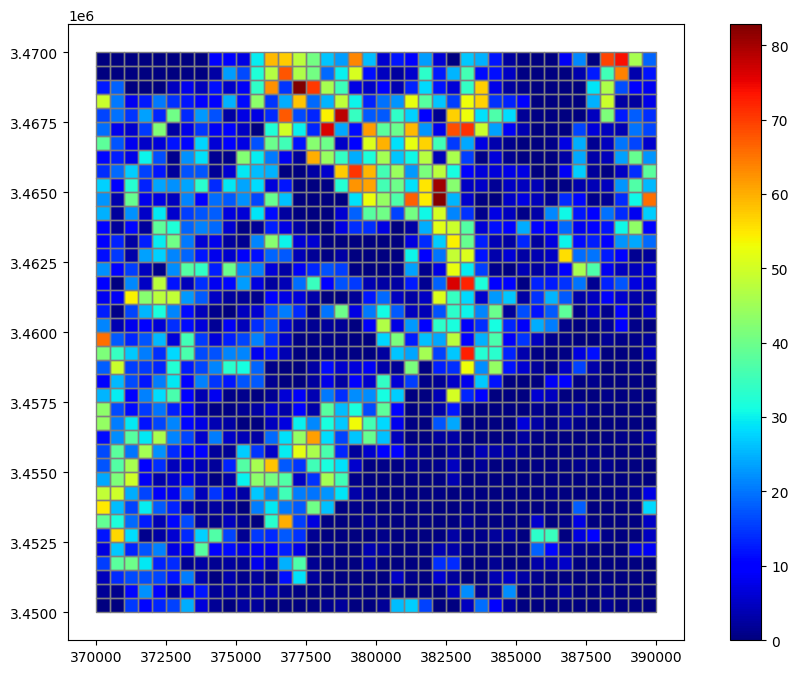

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 8))
dissolve_merged.plot(ax=ax, column='area_density', cmap='jet', legend = True) # here, cmap = 'jet' specifies the colour ramp I've chosen to use.
plt.autoscale(True)
grid.plot(ax=ax, facecolor="none", edgecolor='grey') # this is where you overlay the grid


In Exercise 1 you calculated the point density of landslides and explored kernel density estimates. In Exercise 2 you calculated the area density of landslides.

**Compare and contrast the resulting patterns of landslides from these different types of analyses. Have a think about which approach is most useful and why, given different hazards we're interested in, and the different data formats available to us (e.g. point/polygon/line) representations of hazards**



##Extra task
Have a play around with the grid size and evaluate effects of changing cell size on the resulting patterns of landslide area density.